This notebook is used for the first section analysis, i.e. Bayesian Optimization succesfully identifies effective mixtures in low-domain setting

In [15]:
%matplotlib inline
import sys
sys.path.append("../")

from law import read_experiments, parse_results, fit, optimize
import numpy as np
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict, Trial, TrialType
from typing import List
import random
import matplotlib.pyplot as plt

In [16]:
optimization_run_path = "../logs/bayesian_books_cc_stack_few_init_0/experiment_history.yaml"
initialization_run_path = "../logs/uniform_books_cc_stack_0/experiment_history.yaml"
mixing_laws_run_path="../logs/books_cc_stack_few_determinisitc_init_0/experiment_history.yaml"
no_trials = 16

In [17]:
# optimization_run_path = "/root/code/mixture_optimization/logs/bayesian-two-sources_0/experiment_history.yaml"
# initialization_run_path = "../logs/lin_interp_books_cc_0/experiment_history.yaml"
# no_trials = 16

In [18]:
optimization_experiment = read_experiments(optimization_run_path)[0]
initialization_experiment = read_experiments(initialization_run_path)[0]

assert len(optimization_experiment.trials) >= no_trials
if len(initialization_experiment.trials) < no_trials:
    no_trials_init = len(initialization_experiment.trials)
    print(f"Warning: Not enough trials in initialization experiment. Using {no_trials_init} trials instead.")
else:
    no_trials_init = no_trials
    
optimization_trials = optimization_experiment.trials[:no_trials]
initialization_trials_random_sample = np.random.choice(initialization_experiment.trials, no_trials_init, replace=False)

In [19]:
def get_weighted_val_perplexity(trials: List[Trial]):
    return [trial.weighted_val_perplexity  for trial in trials]

def get_weights(trials: List[Trial]):
    return [trial.true_mixing_weights for trial in trials]

def get_best_perplexity(trials: List[Trial]):
    perplexities = get_weighted_val_perplexity(trials)
    weights = get_weights(trials)
    best_perplexity = min(perplexities)
    best_weight = weights[perplexities.index(best_perplexity)]
    return best_perplexity, best_weight

def get_best_init_perlexity(trials: List[Trial]):
    init_tirals = [trial for trial in trials if trial.type == TrialType.INITIALIZATION]
    return get_best_perplexity(init_tirals)


In [20]:
init_perplexity, init_weights = get_best_init_perlexity(initialization_trials_random_sample)
print(f"Initialization achieved best perplexity of {init_perplexity}. This was achieved with weights {init_weights}")
optim_perplexity, optim_weights = get_best_perplexity(optimization_trials)
print(f"Optimization achieved best perplexity of {optim_perplexity} with weights {optim_weights}. This was after being initialized from best init perpelxity of {get_best_init_perlexity(optimization_trials)}")

Initialization achieved best perplexity of 4.08139352997144. This was achieved with weights {'Books': 0.2234930288474615, 'CC': 0.3491043306551197, 'stack-v4': 0.4274026404974188}
Optimization achieved best perplexity of 4.041197016835213 with weights {'Books': 0.22264441410223632, 'CC': 0.26032617269310065, 'stack-v4': 0.517029413204663}. This was after being initialized from best init perpelxity of (4.064853901664415, {'Books': 0.29958004449787573, 'CC': 0.21359796332461145, 'stack-v4': 0.4868219921775128})


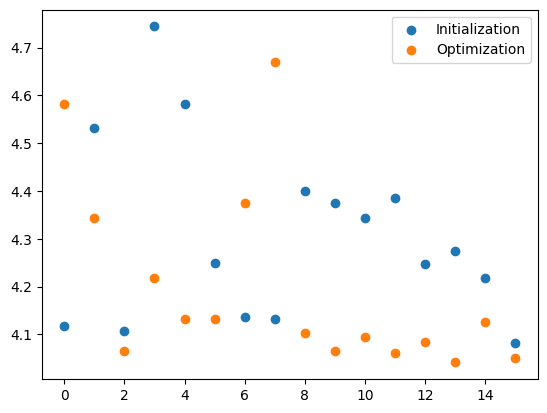

In [21]:
# plot initialization vs optimizaiton in same scatter plot
fig, ax = plt.subplots()
ax.scatter(range(len(initialization_trials_random_sample)), get_weighted_val_perplexity(initialization_trials_random_sample), label="Initialization")
ax.scatter(range(len(optimization_trials)),get_weighted_val_perplexity(optimization_trials), label="Optimization")
ax.legend()

In [22]:
# also add fit 
from copy import deepcopy


def func1(r, B, b):
    return B/ (r**b)

init_experiment_cut = deepcopy(initialization_experiment)
init_experiment_cut.trials = initialization_trials_random_sample

init_results_fit = parse_results(init_experiment_cut, -1)
best_params, best_val = fit(init_experiment_cut, func1, region=(0.1, 0.9), eval_idx=-1)
best_weights, pred_value = optimize(func1, best_params)

print(f"After fitting best predicted perplexity is {pred_value}. Best weights are {best_weights}")

After fitting best predicted perplexity is 4.043319907282755. Best weights are [0.19234131 0.23381694 0.57384175]


In [23]:
mixing_laws_experiment = read_experiments(mixing_laws_run_path)[0]
assert len(mixing_laws_experiment.trials) == 1
mixing_weighted_val_perplexity = mixing_laws_experiment.trials[0].weighted_val_perplexity

print(f"Mixing laws predicted perplexity {pred_value} and achieved perplexity {mixing_weighted_val_perplexity}")

Mixing laws predicted perplexity 4.043319907282755 and achieved perplexity 4.083900471528371


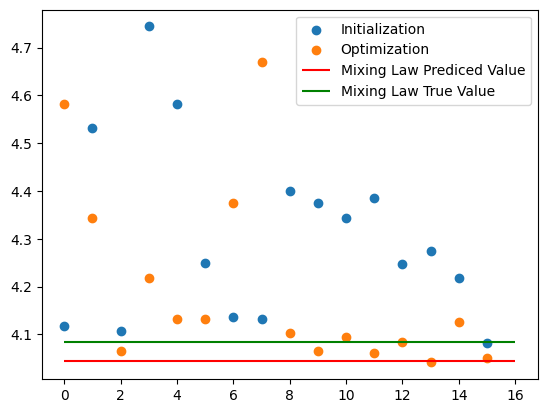

In [26]:
# plot initialization vs optimizaiton in same scatter plot
fig, ax = plt.subplots()
ax.scatter(range(no_trials), get_weighted_val_perplexity(initialization_trials_random_sample), label="Initialization")
ax.scatter(range(no_trials),get_weighted_val_perplexity(optimization_trials), label="Optimization")

# add h line for best predicted value
ax.hlines(pred_value, 0, no_trials, color="red", label="Mixing Law Prediced Value")
ax.hlines(mixing_weighted_val_perplexity, 0, no_trials, color="green", label="Mixing Law True Value")

ax.legend()